Chapter 10 - Working with Symbolic Expressions
==============================================

In [1]:
from abc import ABC, abstractmethod
import math
from matplotlib import pyplot as plt
import numpy as np

In [2]:

def plot_function(f,tmin,tmax,tlabel=None,xlabel=None,axes=False, **kwargs):
    ts = np.linspace(tmin,tmax,1000)
    if tlabel:
        plt.xlabel(tlabel,fontsize=18)
    if xlabel:
        plt.ylabel(xlabel,fontsize=18)
    plt.plot(ts, [f(t) for t in ts], **kwargs)
    if axes:
        total_t = tmax-tmin
        plt.plot([tmin-total_t/10,tmax+total_t/10],[0,0],c='k',linewidth=1)
        plt.xlim(tmin-total_t/10,tmax+total_t/10)
        xmin, xmax = plt.ylim()
        plt.plot([0,0],[xmin,xmax],c='k',linewidth=1)
        plt.ylim(xmin,xmax)

In [3]:
def plot_volume(f,tmin,tmax,axes=False,**kwargs):
    plot_function(f,tmin,tmax,tlabel="time (hr)", xlabel="volume (bbl)", axes=axes, **kwargs)

def plot_flow_rate(f,tmin,tmax,axes=False,**kwargs):
    plot_function(f,tmin,tmax,tlabel="time (hr)", xlabel="flow rate (bbl/hr)", axes=axes, **kwargs)

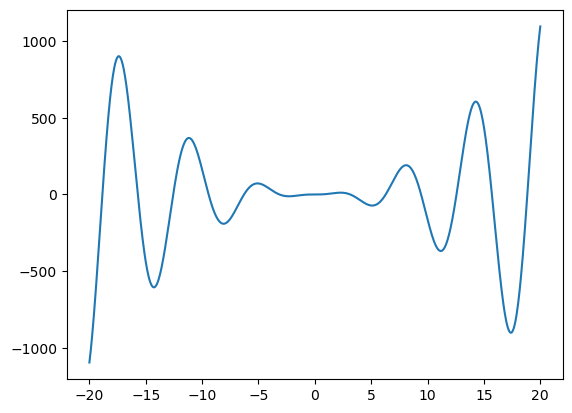

In [4]:
def f(x):
    return (3 * x ** 2) * math.sin(x)
plot_function(f, tmin=-20, tmax=20)

In [5]:
def paren_if_instance(exp,*args):
    for typ in args:
        if isinstance(exp,typ):
            return "\\left( {} \\right)".format(exp.latex())
    return exp.latex()

def package(maybe_expression):
    if isinstance(maybe_expression,Expression):
        return maybe_expression
    elif isinstance(maybe_expression,int) or isinstance(maybe_expression,float):
        return Number(maybe_expression)
    else:
        raise ValueError("can't convert {} to expression.".format(maybe_expression))
def dot_if_necessary(latex):
    if latex[0] in '-1234567890':
        return '\\cdot {}'.format(latex)
    else:
        return latex
        
class Expression(ABC):
    @abstractmethod
    def latex(self):
        pass
    def _repr_latex_(self):
        return "$$" + self.latex() + "$$"
    @abstractmethod
    def evaluate(self, **bindings):
        pass
    @abstractmethod
    def substitute(self, var, expression):
        pass
    @abstractmethod
    def expand(self):
        pass
    @abstractmethod
    def display(self):
        pass
    def __repr__(self):
        return self.display()
    @abstractmethod
    def derivative(self,var):
        pass
    
    def __call__(self, *inputs):
        var_list = sorted(distinct_variables(self))
        return self.evaluate(**dict(zip(var_list, inputs)))
    
    def __add__(self, other):
        return Sum(self,package(other))
    
    def __sub__(self,other):
        return Difference(self,package(other))
    
    def __mul__(self,other):
        return Product(self,package(other))
    
    def __rmul__(self,other):
        return Product(package(other),self)
    
    def __truediv__(self,other):
        return Quotient(self,package(other))
    
    def __pow__(self,other):
        return Power(self,package(other))
    
    @abstractmethod
    def _python_expr(self):
        pass
    
    def python_function(self,**bindings):
#         code = "lambda {}:{}".format(
#             ", ".join(sorted(distinct_variables(self))),
#             self._python_expr())
#         print(code)
        global_vars = {"math":math}
        return eval(self._python_expr(),global_vars,bindings)

class Sum(Expression):
    def __init__(self, *exps):
        self.exps = exps
    def latex(self):
        return " + ".join(exp.latex() for exp in self.exps)
    def evaluate(self, **bindings):
        return sum([exp.evaluate(**bindings) for exp in self.exps])
    def expand(self):
        return Sum(*[exp.expand() for exp in self.exps])
    def display(self):
        return "Sum({})".format(",".join([e.display() for e in self.exps]))
    def derivative(self, var):
        return Sum(*[exp.derivative(var) for exp in self.exps])
    def substitute(self, var, new):
        return Sum(*[exp.substitute(var,new) for exp in self.exps])
    def _python_expr(self):
        return "+".join("({})".format(exp._python_expr()) for exp in self.exps)
    
class Product(Expression):
    def __init__(self, exp1, exp2):
        self.exp1 = exp1
        self.exp2 = exp2
    def latex(self):
        return "{}{}".format(
            paren_if_instance(self.exp1,Sum,Negative,Difference),
            dot_if_necessary(paren_if_instance(self.exp2,Sum,Negative,Difference)))
    def evaluate(self, **bindings):
        return self.exp1.evaluate(**bindings) * self.exp2.evaluate(**bindings)
    def expand(self):
        expanded1 = self.exp1.expand()
        expanded2 = self.exp2.expand()
        if isinstance(expanded1, Sum):
            return Sum(*[Product(e,expanded2).expand() for e in expanded1.exps])
        elif isinstance(expanded2, Sum):
            return Sum(*[Product(expanded1,e) for e in expanded2.exps])
        else:
            return Product(expanded1,expanded2)
        
    def display(self):
        return "Product({},{})".format(self.exp1.display(),self.exp2.display())
    
    def derivative(self,var):
        if not contains(self.exp1, var):
            return Product(self.exp1, self.exp2.derivative(var))
        elif not contains(self.exp2, var):
            return Product(self.exp1.derivative(var), self.exp2)
        else:
            return Sum(
                Product(self.exp1.derivative(var), self.exp2),
                Product(self.exp1, self.exp2.derivative(var)))

    def substitute(self, var, exp):
        return Product(self.exp1.substitute(var,exp), self.exp2.substitute(var,exp))
    
    def _python_expr(self):
        return "({})*({})".format(self.exp1._python_expr(), self.exp2._python_expr())
    
class Difference(Expression):
    def __init__(self,exp1,exp2):
        self.exp1 = exp1
        self.exp2 = exp2
    def latex(self):
        return "{} - {}".format(
            self.exp1.latex(),
            paren_if_instance(self.exp2,Sum,Difference,Negative))
    def evaluate(self, **bindings):
        return self.exp1.evaluate(**bindings) - self.exp2.evaluate(**bindings)
    def expand(self):
        return self
    def display(self):
        return "Difference({},{})".format(self.exp1.display(), self.exp2.display())
    def derivative(self,var):
        return Difference(self.exp1.derivative(var),self.exp2.derivative(var))
    def substitute(self, var, exp):
        return Difference(self.exp1.substitute(var,exp), self.exp2.substitute(var,exp))   
    def _python_expr(self):
        return "({}) - ({})".format(self.exp1._python_expr(), self.exp2._python_expr())
    
class Quotient(Expression):
    def __init__(self,numerator,denominator):
        self.numerator = numerator
        self.denominator = denominator
    def latex(self):
        return "\\frac{{ {} }}{{ {} }}".format(self.numerator.latex(),self.denominator.latex())
    def evaluate(self, **bindings):
        return self.numerator.evaluate(**bindings) / self.denominator.evaluate(**bindings)
    def expand(self):
        return self
    def display(self):
        return "Quotient({},{})".format(self.numerator.display(),self.denominator.display())
    def substitute(self, var, exp):
        return Quotient(self.numerator.substitute(var,exp), self.denominator.substitute(var,exp))
    def derivative(self, var):
        return Quotient(
            Difference(
                Product(self.denominator, self.numerator.derivative(var)),
                Product(self.numerator, self.denominator.derivative(var))
            ),
            Power(self.denominator,Number(2)))
    def _python_expr(self):
        return "({}) / ({})".format(self.exp1._python_expr(), self.exp2._python_expr())
    
class Negative(Expression):
    def __init__(self,exp):
        self.exp = exp
    def latex(self):
        return "- {}".format(
            paren_if_instance(self.exp,Sum,Difference,Negative))
    def evaluate(self, **bindings):
        return - self.exp.evaluate(**bindings)
    def expand(self):
        return self
    def derivative(self,var):
        return Negative(self.exp.derivative(var))
    def substitute(self,var,exp):
        return Negative(self.exp.substitute(var,exp))
    def _python_expr(self):
        return "- ({})".format(self.exp._python_expr())
    def display(self):
        return "Negative({})".format(self.exp.display())
    
class Number(Expression):
    def __init__(self,number):
        self.number = number
    def latex(self):
        return str(self.number)
    def evaluate(self, **bindings):
        return self.number
    def expand(self):
        return self
    def display(self):
        return "Number({})".format(self.number)
    def derivative(self,var):
        return Number(0)
    def substitute(self,var,exp):
        return self
    def _python_expr(self):
        return str(self.number)
    
class Power(Expression):
    def __init__(self,base,exponent):
        self.base = base
        self.exponent = exponent
    def latex(self):
        return "{} ^ {{ {} }}".format(
            paren_if_instance(self.base, Sum, Negative, Difference, Quotient, Product),
            self.exponent.latex())
    def evaluate(self, **bindings):
        return self.base.evaluate(**bindings) ** self.exponent.evaluate(**bindings)
    def expand(self):
        return self
#         expanded_exponent = self.exponent.expand()
#         print (expanded_exponent)
#         if isinstance(expanded_exponent, Number)\
#             and (expanded_exponent.number % 1 == 0)\
#             and (expanded_exponent.number > 0):
#                 power = int(expanded_exponent.number)
#                 if power == 1:
#                     return self.base.expand()
#                 else:
#                     return Product(self.base.expand(), Power(self.base,Number(power-1)).expand()).expand()
#         else:
#             return Power(self.base.expand, expanded_exponent)
    def display(self):
        return "Power({},{})".format(self.base.display(),self.exponent.display())
    def derivative(self,var):
        if isinstance(self.exponent, Number):
            power_rule = Product(
                    Number(self.exponent.number), 
                    Power(self.base, Number(self.exponent.number - 1)))
            return Product(self.base.derivative(var),power_rule)
        elif isinstance(self.base, Number):
            exponential_rule = Product(Apply(Function("ln"),Number(self.base.number)), self)
            return Product(self.exponent.derivative(var), exponential_rule)
        else:
            raise Exception("couldn't take derivative of power {}".format(self.display()))
    def substitute(self,var,exp):
        return Power(self.base.substitute(var,exp), self.exponent.substitute(var,exp))
    
    def _python_expr(self):
        return "({}) ** ({})".format(self.base._python_expr(), self.exponent._python_expr())
    
class Variable(Expression):
    def __init__(self,symbol):
        self.symbol = symbol
    def latex(self):
        return self.symbol
    def evaluate(self, **bindings):
        return bindings[self.symbol]
    def expand(self):
        return self
    def display(self):
        return "Variable(\"{}\")".format(self.symbol)
    def derivative(self, var):
        if self.symbol == var.symbol:
            return Number(1)
        else:
            return Number(0)
    def substitute(self, var, exp):
        if self.symbol == var.symbol:
            return exp
        else:
            return self
        
    def _python_expr(self):
        return self.symbol
        
class Function():
    def __init__(self,name,make_latex=None):
        self.name = name
        self.make_latex = make_latex
    def latex(self,arg_latex):
        if self.make_latex:
            return self.make_latex(arg_latex)
        else:
            return " \\operatorname{{ {} }} \\left( {} \\right)".format(self.name, arg_latex)
  
class Apply(Expression):
    def __init__(self,function,argument):
        self.function = function
        self.argument = argument
    def latex(self):
        return self.function.latex(self.argument.latex())
#         return "\\operatorname{{ {} }} \\left( {} \\right)".format(self.function.name, self.argument.latex())
    def evaluate(self, **bindings):
        return _function_bindings[self.function.name](self.argument.evaluate(**bindings))
    def expand(self):
        return Apply(self.function, self.argument.expand())
    def display(self):
        return "Apply(Function(\"{}\"),{})".format(self.function.name, self.argument.display())
    def derivative(self, var):
        return Product(
                self.argument.derivative(var), 
                _derivatives[self.function.name].substitute(_var, self.argument))
    def substitute(self,var,exp):
        return Apply(self.function, self.argument.substitute(var,exp))
    
    def _python_expr(self):
        return _function_python[self.function.name].format(self.argument._python_expr())

_function_bindings = {
    "sin": math.sin,
    "cos": math.cos,
    "ln": math.log,
    "sqrt": math.sqrt
}

_function_python = {
    "sin": "math.sin({})",
    "cos": "math.cos({})",
    "ln": "math.log({})",
    "sqrt": "math.sqrt({})"
}

_var = Variable('placeholder variable')

_derivatives = {
    "sin": Apply(Function("cos"), _var),
    "cos": Product(Number(-1), Apply(Function("sin"), _var)),
    "ln": Quotient(Number(1), _var),
    "sqrt": Quotient(Number(1), Product(Number(2), Apply(Function("sqrt"), _var)))
}
    
x = Variable('x')
y = Variable('y')
z = Variable('z')
a = Variable('a')
b = Variable('b')

def _apply(func_name):
    return (lambda x: Apply(Function(func_name), x))

Sin = _apply("sin")
Cos = _apply("cos")
Sqrt = lambda exp: Apply(Function('sqrt', lambda s: "\\sqrt{{ {} }}".format(s)), exp)

def distinct_variables(exp):
    if isinstance(exp, Variable):
        return set(exp.symbol)
    elif isinstance(exp, Number):
        return set()
    elif isinstance(exp, Sum):
        return set().union(*[distinct_variables(exp) for exp in exp.exps])
    elif isinstance(exp, Product):
        return distinct_variables(exp.exp1).union(distinct_variables(exp.exp2))
    elif isinstance(exp, Power):
        return distinct_variables(exp.base).union(distinct_variables(exp.exponent))
    elif isinstance(exp, Apply):
        return distinct_variables(exp.argument)
    else:
        raise TypeError("Not a valid expression.")
        
def contains(exp, var):
    if isinstance(exp, Variable):
        return exp.symbol == var.symbol
    elif isinstance(exp, Number):
        return False
    elif isinstance(exp, Sum):
        return any([contains(e,var) for e in exp.exps])
    elif isinstance(exp, Product):
        return contains(exp.exp1,var) or contains(exp.exp2,var)
    elif isinstance(exp, Power):
        return contains(exp.base, var) or contains(exp.exponent, var)
    elif isinstance(exp, Apply):
        return contains(exp.argument, var)
    else:
        raise TypeError("Not a valid expression.")

# TODO: equality
# TODO: evalb
# TODO: substitution
# TODO: derivative

f_expression = (
    Product(
        Sum(
            Product(Number(3), Power(Variable("x"), Number(2))),
            Variable("x")),
        Apply(Function("sin"), Variable("x")))
)
f_expression

Product(Sum(Product(Number(3),Power(Variable("x"),Number(2))),Variable("x")),Apply(Function("sin"),Variable("x")))

#### 10.2.4 Exercises

In [6]:
##### Exercise 10.2
def f(y, z):
    return math.log(y**z)

f(2,4)

2.772588722239781

In [7]:
##### Exercise 10.7

A = Variable("A")
B = Variable("B")
C = Variable("C")

Sqrt = Function("sqrt")

Quotient(
    Sum(
        Negative(B),
        Apply(
            Sqrt,
            Difference(
                Power(B, Number(2)),
                Product(Number(4), Product(A,C))))),
    Product(Number(2), A))


Quotient(Sum(Negative(Variable("B")),Apply(Function("sqrt"),Difference(Power(Variable("B"),Number(2)),Product(Number(4),Product(Variable("A"),Variable("C")))))),Product(Number(2),Variable("A")))

#### 10.3 Putting symbolic expression to work

In [8]:
distinct_variables(Variable("z"))

{'z'}

In [9]:
distinct_variables(Number(3))

set()

In [10]:
f_expression = (
    Product(
        Sum(
            Product(Number(3), Power(Variable("x"), Number(2))),
            Variable("x")),
        Apply(Function("sin"), Variable("x")))
)
f_expression.evaluate(x=5)

-76.71394197305108

#### 10.3.3 Expanding an expresssion

In [11]:
Y = Variable('y')
Z = Variable('z')
A = Variable('a')
B = Variable('b')

Product(Sum(A,B),Sum(Y,Z))


Product(Sum(Variable("a"),Variable("b")),Sum(Variable("y"),Variable("z")))

In [12]:
Product(Sum(A,B),Sum(Y,Z)).expand()

Sum(Sum(Product(Variable("a"),Variable("y")),Product(Variable("a"),Variable("z"))),Sum(Product(Variable("b"),Variable("y")),Product(Variable("b"),Variable("z"))))

In [13]:
f_expression.expand()

Sum(Product(Product(Number(3),Power(Variable("x"),Number(2))),Apply(Function("sin"),Variable("x"))),Product(Variable("x"),Apply(Function("sin"),Variable("x"))))